# Trunk Width Estimation Demo/Visualizations
## Initial Setup
The package handles paths using the PackagePaths object, it expects two environment variables to exist:
- WIDTH_ESTIMATION_PACKAGE_PATH: Points to the main package directory location
- WIDTH_ESTIMATION_PACKAGE_DATA_PATH: Points to the directory with the package data, including the model and test images.

See the [Package Data section of the README](https://github.com/Jostan86/trunk_width_estimation/tree/main?tab=readme-ov-file#package-data) for more information on the path setup, data downloads, and expected directory structure. 

For this script, the 'Main Data' is needed, but not the 'Analysis Data'

In [1]:
import os
from trunk_width_estimation import TrunkAnalyzer, TrunkAnalyzerData, PackagePaths

# ----- Set the package paths -----
# These are environment variables that are set to the paths of the package and package data. The PackagePaths object needs these to exist.
# They can be set in the environment or directly in the code.

# Package path is the path to the trunk_width_estimation folder.
# package_path = "/path/to/trunk_width_estimation"
# os.environ['WIDTH_ESTIMATION_PACKAGE_PATH'] = package_path

# Package data path is the path to the trunk_width_estimation_package_data folder.
# package_data_path = "/path/to/trunk_width_estimation_package_data"
# os.environ['WIDTH_ESTIMATION_PACKAGE_DATA_PATH'] = package_data_path

# All the paths for the package are set in the PackagePaths class
package_paths = PackagePaths(config_file="width_estimation_config_apple.yaml")

# Create the trunk analyzer objects, set the create_vis_flag to True to create visualizations for each operation
trunk_analyzer = TrunkAnalyzer(package_paths, create_vis_flag=True)

## Add some helper functions

In [2]:
from typing import List
from trunk_width_estimation.width_estimation import ProcessVisualization, TrunkAnalyzerAbstractOperation
import cv2
import matplotlib.pyplot as plt

def run_operation(operation: TrunkAnalyzerAbstractOperation, trunk_analyzer_data: TrunkAnalyzerData):
    """A helper function to run one of the trunk width estimation operations and show the results"""
    trunk_analyzer_data = operation.run_and_analyze(trunk_analyzer_data, create_vis_flag=True)
    show_image(operation.visualizations)

    return trunk_analyzer_data

def show_image(visualizations: List[ProcessVisualization]):
    """A helper function to show the image with the visualizations"""
    num_visualizations = len(visualizations)
    fig, axs = plt.subplots(num_visualizations, 1, figsize=(15, 5*num_visualizations))
    if num_visualizations == 1:
        axs = [axs]
    for i, vis in enumerate(visualizations):
        vis.add_metrics_to_image()
        image = cv2.cvtColor(vis.image, cv2.COLOR_BGR2RGB)
        axs[i].imshow(image)
        axs[i].axis("off")
    plt.show()

## Load the image
Load an image using the paths in the package paths object.

The trunk ```TrunkAnalyzerData``` object holds the data and is used to pass data between operations smoothly. It also has some helper methods for visualizing and utilizing the data. 

In [3]:
# This image is selected because it has a trunk and a post
image_index = 200
# Get the image paths for the image
rgb_image_path = package_paths.rgb_test_image_paths[image_index]
depth_image_path = package_paths.depth_test_image_paths[image_index]
# Make a TrunkAnalyzerData object using the image paths
trunk_analyzer_data = TrunkAnalyzerData.from_image_paths(rgb_image_path, depth_image_path)

## Run each of the operations on the image
Most of the operations have parameters that can be set in the config file. Some operations can also be disabled in the config file. There is more information about each parameter in the [config file itself](https://github.com/Jostan86/trunk_width_estimation/blob/main/config/width_estimation_config_apple.yaml).
### Trunk Segmenter
Run the image through the segmentation model to segment out posts, trunks, and sprinklers. 

Settable Parameters:
- **seg_model_confidence_threshold**: (float) Confidence threshold for model to use.
- **seg_model_nms_threshold**: (float) Threshold for Yolo's built in NMS filter (only filters if class is the same).

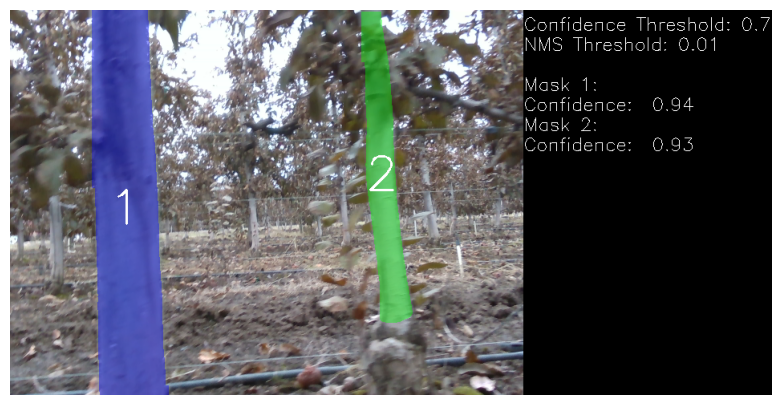

In [4]:
operation = trunk_analyzer.trunk_segmenter
trunk_analyzer_data = run_operation(operation, trunk_analyzer_data)

### Object Type Filter
The object type filter removes any sprinklers and sets the class numbers to match what is expected by the rest of the algorithm. 

Settable Parameters:
- **seg_model_trunk_class**: (int) 
- **seg_model_post_class**: (int)

These are the class numbers the **MODEL** outputs for the trunks and posts, this will be used to change them so that trunks are 0, posts are 1, and others are 2 (as the particle filter expects).


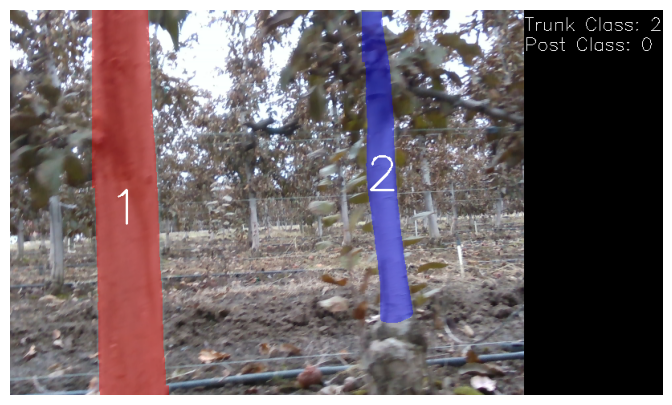

In [5]:
operation = trunk_analyzer.object_type_filter
trunk_analyzer_data = run_operation(operation, trunk_analyzer_data)

### Largest Segment Finder
The largest segment finder ensures that the mask consists of only one segment (most already do).

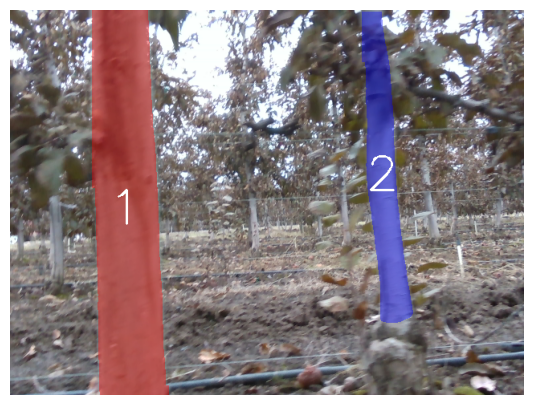

In [6]:
operation = trunk_analyzer.largest_seg_finder
trunk_analyzer_data = run_operation(operation, trunk_analyzer_data)

### NMS Filter
The non-maximum suppression filter removes overlapping masks of different classes (Same class masks are already suppressed by the YOLO model).

Settable Parameters:
- **filter_nms_overlap_threshold**: (float) Overlap threshold for masks of different classes.
- **include_nms_filter**: (bool) Whether to include this filter.

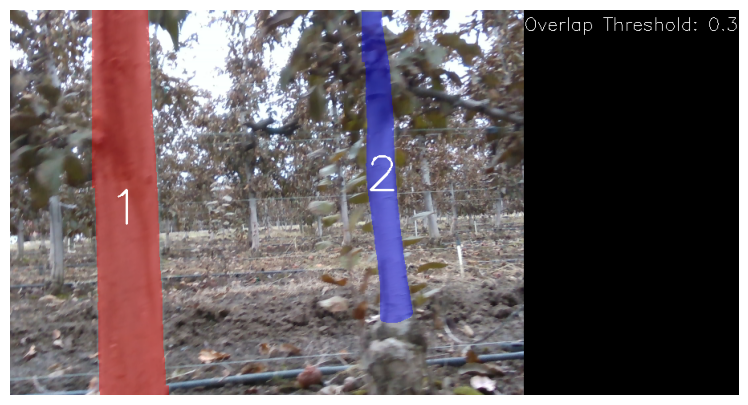

In [7]:
operation = trunk_analyzer.filter_nms
trunk_analyzer_data = run_operation(operation, trunk_analyzer_data)

### Depth Calculation
The depth calculation operation calculates the best estimate of the distance between the object and camera. It looks at a central region of the mask and estimates the depth as a given percentile of the values (So at 65, the percentile depth will be farther than 65% of the points in the mask). It also filters out masks that have less than a given number of valid points in the given region. 

Settable Parameters:
- **depth_calc_percentile**: (float) Percentile of the depth values to use for the depth estimate. 
- **depth_calc_min_num_points**: (int) Number of points needed in the set region for the mask to be considered valid.
- **depth_calc_top_ignore**: (float) Proportion of the top of the image to ignore mask points in when calculating the depth. 
- **depth_calc_bottom_ignore**: (float) Proportion of the bottom of the image to ignore mask points in when calculating the depth


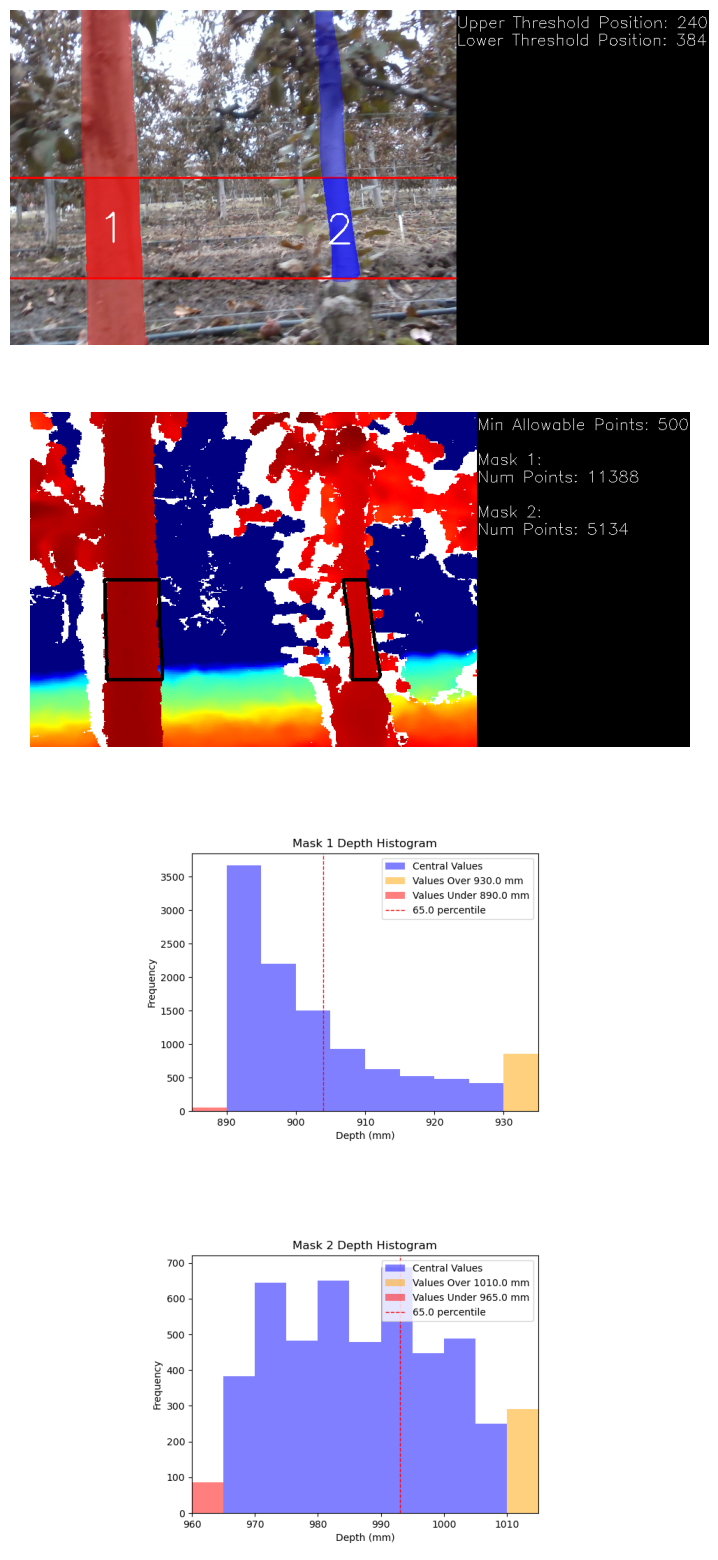

In [8]:
operation = trunk_analyzer.depth_calculation
trunk_analyzer_data = run_operation(operation, trunk_analyzer_data)

### Depth Filter
Filters out masks whose estimated depth is beyond a threshold.

Settable Parameters:
- **filter_depth_max_depth**: (float) The maximum distance allowed for object (in meters), if farther than this the segmentation is removed.
- **include_depth_filter**: (bool) Whether to include this filter.

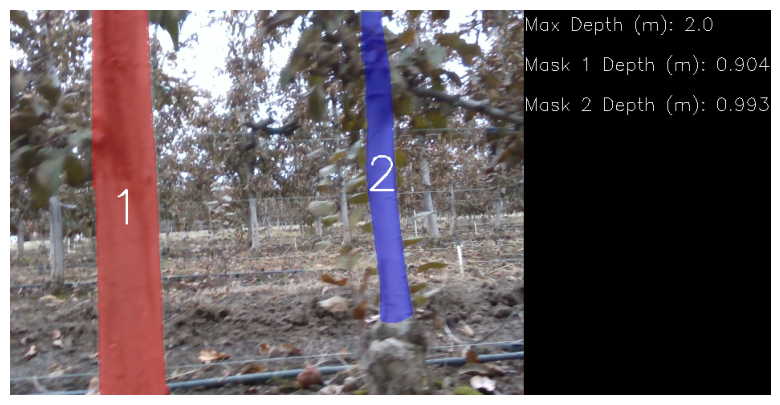

In [9]:
operation = trunk_analyzer.filter_depth
trunk_analyzer_data = run_operation(operation, trunk_analyzer_data)

### Edge Proximity Filter
The edge filter removes masks too close to the edge. With the default settings, masks with more than 10% of their pixels within the leftmost or rightmost 5% of the image will be removed.

Settable Parameters:
- **filter_edge_edge_threshold**: (float) Proportion of the image width that is considered the edge.
- **filter_edge_size_threshold**: (float) Proportion of the mask that must be in the edge 'zone' for the mask to be removed.
- **include_edge_filter**: (bool) Whether to include this filter.

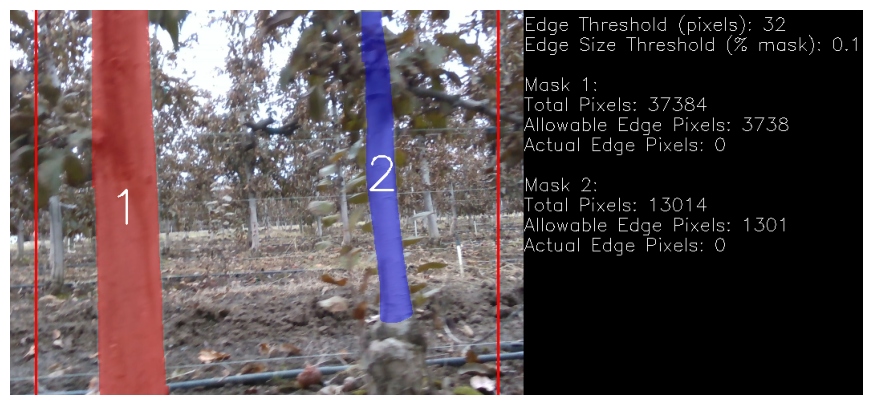

In [10]:
operation = trunk_analyzer.filter_edge
trunk_analyzer_data = run_operation(operation, trunk_analyzer_data)

### Position Filter
The position filter removes any masks that are either too high or too low in the image.

Settable Parameters:
- **filter_position_bottom_threshold**: (float) If the bottom of the mask is above this threshold, the mask is considered to be too high and is removed. The value is the percentage of the image height up from the bottom.
- **filter_position_top_threshold**: (float) If the top of the mask is below this threshold, the mask is considered to be too low. The value is the percentage of the image height down from the top.
- **include_position_filter**: (bool) Whether to include this filter.

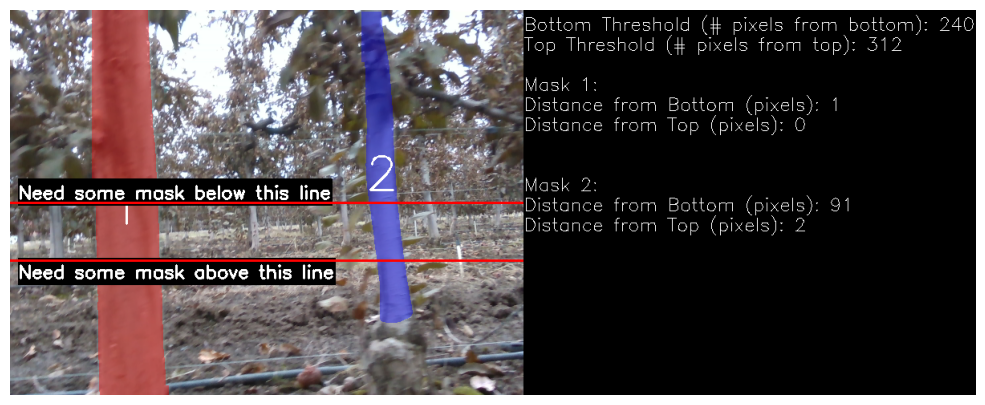

In [11]:
operation = trunk_analyzer.filter_position
trunk_analyzer_data = run_operation(operation, trunk_analyzer_data)

### Width Calculation
This width is calculated in this operation. Looking at the first and second image below, the center-line of the segmentation (blue line) is the points between the right and left side of the mask at each row. The width is first calculated as the number of pixels between the right and left side of the mask along a particular row of the image. Then the angle between each 15th pixel along the center-line (red lines) is used to adjust the original width, these adjusted widths are shown by the green lines. The 50th percentile (so the median) of these is used as the width estimate.

Settable Parameters:
- **pixel_width_segment_length**: (int) Length of the segments to break the centerline down into.
- **pixel_width_percentile**: (float) Percentile of the pixel width to use for the pixel width estimate.

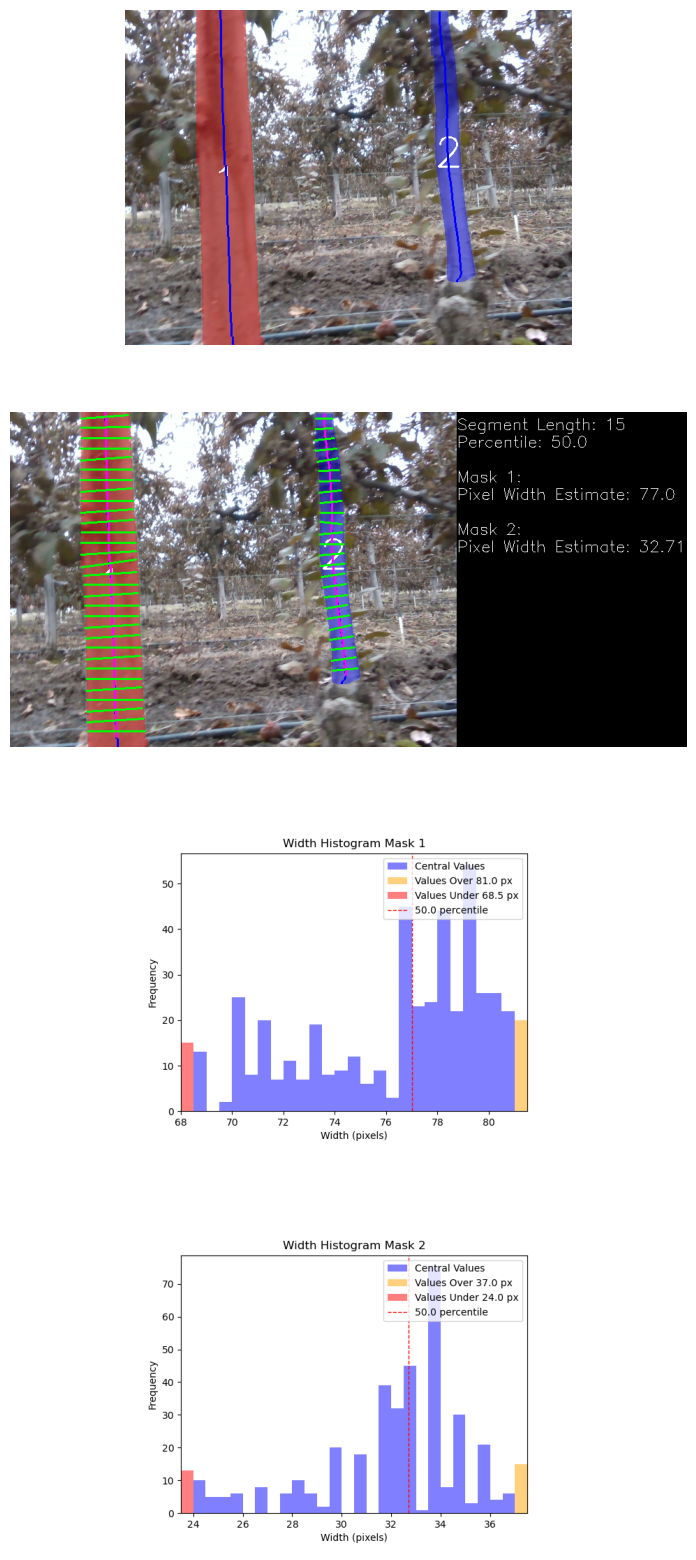

In [12]:
operation = trunk_analyzer.width_estimation
trunk_analyzer_data = run_operation(operation, trunk_analyzer_data)

### Width Correction
The width correction operation applies a linear adjustment to the width estimates, determined by the object's x position in the image. This x position is represented by the red line in the image.

The correction uses this equation: $w_c = w_o + m \cdot x + b$, where:
- $w_c$ is the corrected width
- $w_o$ is the original width
- $m$ is the slope, set by width_correction_slope
- $x$ is the distance between the center of the mask and the center of the image
- $b$ is the intercept, set by width_correction_intercept

Settable Parameters:
- **width_correction_slope**: (float) Slope of the linear correction. 
- **width_correction_intercept**: (float) Intercept of the linear correction.
- **include_width_correction**: (bool) Whether to include this filter.

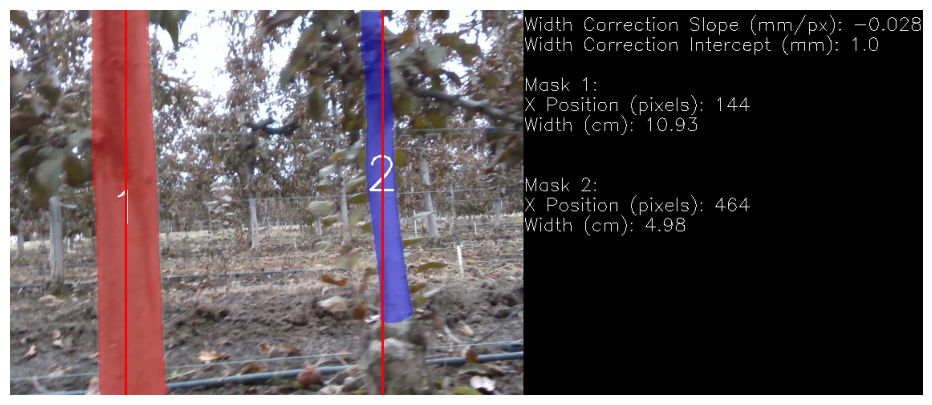

In [13]:
operation = trunk_analyzer.width_correction
trunk_analyzer_data = run_operation(operation, trunk_analyzer_data)

## Print off the results

In [14]:
if trunk_analyzer_data.num_instances == 0:
    print("No trunks found")
else:
    for i in range(trunk_analyzer_data.num_instances):
        print(f"Mask {i+1}:")
        print(f"Estimated width: {trunk_analyzer_data.object_widths[i] * 100} cm")
        print(f"Object Location: {trunk_analyzer_data.object_locations[i]}")
        print(f"Classification: {trunk_analyzer_data.classes[i]}")

Mask 1:
Estimated width: 10.930834767126859 cm
Object Location: [   -0.25883       0.904]
Classification: 1
Mask 2:
Estimated width: 4.980807237336207 cm
Object Location: [    0.23262       0.993]
Classification: 0
